In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pickle
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
tf.config.run_functions_eagerly(True)
from keras.utils import plot_model


import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/kaggle/input/mc90v-full/M2508_train_sensors.csv
/kaggle/input/mc90v-full/M2508_test_sensors.csv
/kaggle/input/mc90v-full/M2508_train_full.csv
/kaggle/input/mc90v-full/M2503_test_full.csv
/kaggle/input/mc90v-full/M2503_train_full.csv
/kaggle/input/mc90v-full/M0000_test_sensors.csv
/kaggle/input/mc90v-full/M2503_train_sensors.csv
/kaggle/input/mc90v-full/M2506_test_full.csv
/kaggle/input/mc90v-full/M0000_train_full.csv
/kaggle/input/mc90v-full/M0000_test_full.csv
/kaggle/input/mc90v-full/M2506_train_sensors.csv
/kaggle/input/mc90v-full/M2506_train_full.csv
/kaggle/input/mc90v-full/M2503_test_sensors.csv
/kaggle/input/mc90v-full/M0000_train_sensors.csv
/kaggle/input/mc90v-full/M2506_test_sensors.csv
/kaggle/input/mc90v-full/M2508_test_full.csv


### Read Data

In [2]:
m0000_train = pd.read_csv('/kaggle/input/mc90v-full/M0000_train_sensors.csv')
m0000_test = pd.read_csv('/kaggle/input/mc90v-full/M0000_test_sensors.csv')
m2503_train = pd.read_csv('/kaggle/input/mc90v-full/M2503_train_sensors.csv')
m2503_test = pd.read_csv('/kaggle/input/mc90v-full/M2503_test_sensors.csv')
m2506_train = pd.read_csv('/kaggle/input/mc90v-full/M2506_train_sensors.csv')
m2506_test = pd.read_csv('/kaggle/input/mc90v-full/M2506_test_sensors.csv')
m2508_train = pd.read_csv('/kaggle/input/mc90v-full/M2508_train_sensors.csv')
m2508_test = pd.read_csv('/kaggle/input/mc90v-full/M2508_test_sensors.csv')

### Preprocesing

In [3]:
def resample(df):
    df = df.interpolate().fillna(df.mean())
    df = df.groupby(df.index // 10).mean()
    return df

def prep(df):
    
    df = df.drop('Linear', axis =1)

    df['Id'] = df.groupby(['Fault', 'RunId', 'Load','SeaTemp', 'WindSpeed']).ngroup() + 1
    df = df.groupby(['Fault', 'RunId', 'Load','SeaTemp', 'WindSpeed']).apply(resample)

    return df

### Target Values

In [4]:
m0000_train['Fault'] = 0
m2503_train['Fault'] = 1
m2506_train['Fault'] = 2
m2508_train['Fault'] = 3

m0000_test['Fault'] = 0
m2503_test['Fault'] = 1
m2506_test['Fault'] = 2
m2508_test['Fault'] = 3

### Train & Validation & Test

In [5]:
train = pd.concat([m0000_train, m2503_train, m2506_train, m2508_train])
test = pd.concat([m0000_test, m2503_test, m2506_test, m2508_test])

In [8]:
train_data = prep(train)
test_data = prep(test)

In [9]:
train_data['Id'] = train_data['Id'].astype(int)
train_data = train_data.drop(['RunId','Fault'],axis=1).reset_index()
train_data['Fault'] = train_data['Fault'].astype(int)
train_data = pd.get_dummies(train_data.drop(['RunId','level_5'],axis=1))

test_data['Id'] = test_data['Id'].astype(int)
test_data = test_data.drop(['RunId','Fault'],axis=1).reset_index()
test_data['Fault'] = test_data['Fault'].astype(int)
test_data = pd.get_dummies(test_data.drop(['RunId','level_5'],axis=1))

In [11]:
print(np.bincount(train_data['Fault']))

[78449 76794 64400 71201]


### Model

In [12]:
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf

class LSTMClassifier():
    def __init__(self, train_data, test_data, window_size=10, batch=32, epoch=100, verbose=1):
        tf.config.run_functions_eagerly(True)

        self.train = train_data
        self.test = test_data
        self.val = None
        
        self.window_size = window_size
        self.num_classes = 4
        self.num_features = 52
        self.batch = batch
        self.epoch = epoch
        self.verbose = verbose
        
        self.scaler = StandardScaler()
        self.model = self.createLSTM()
        self.history = None

    def createLSTM(self):        
        model = Sequential()
        model.add(LSTM(units=64, input_shape=(self.window_size, self.num_features), return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=32))
        model.add(Dropout(0.2))
        model.add(Dense(units=self.num_classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'], run_eagerly=True)
        return model

    def prepare_data(self, data):
        X_sequences, y_sequences = [], []

        for run in np.unique(data['Id']):
            sub_data = data[data['Id'] == run].drop('Id',axis=1)
            X = self.scaler.transform(sub_data.drop('Fault',axis=1))
            y = to_categorical(sub_data['Fault'], self.num_classes)
            
            for i in range(len(X) - self.window_size + 1):
                X_sequences.append(X[i:i+self.window_size])
                y_sequences.append(y[i+self.window_size-1])

        return np.array(X_sequences), np.array(y_sequences)

    def stratified_group_kfold(self,train_data, n_splits=5):
        group_to_fault = train_data.drop_duplicates('Id').set_index('Id')['Fault'].to_dict()
        unique_groups = np.unique(train_data['Id'].values)
        group_labels = [group_to_fault[group] for group in unique_groups]
        strat_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)

        for train_group_idx, valid_group_idx in strat_kfold.split(unique_groups, group_labels):
            train_fold = train_data[train_data['Id'].isin(unique_groups[train_group_idx])]
            valid_fold = train_data[train_data['Id'].isin(unique_groups[valid_group_idx])]
            yield train_fold, valid_fold

    def fit(self):
        
        best_val_acc = 0
        best_model = None

        for train_fold, val_fold in self.stratified_group_kfold(self.train, n_splits=5):
            self.train = train_fold
            self.val = val_fold
            
            # Scaling
            self.scaler.fit(self.train.drop(['Id', 'Fault'], axis=1))

            # Prepare Train and Validation data
            self.X_val, self.y_val  = self.prepare_data(self.val)
            X_train, y_train = self.prepare_data(self.train)
            
            # Model Resetleme
            self.model = self.createLSTM()

            early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

            # Training Model for this fold
            history = self.model.fit(
                X_train, y_train,
                batch_size=self.batch,
                epochs=self.epoch,
                verbose=self.verbose,
                validation_data=(self.X_val, self.y_val),
                callbacks=[early_stop]
            )
            
            current_val_acc = max(history.history['val_accuracy'])
            
            if current_val_acc > best_val_acc:
                best_val_acc = current_val_acc
                self.history = history
                best_model = self.model

        self.model = best_model
        
        print(f"Train Fault Distribution{np.bincount(self.train['Fault'])}")
        print(f"Validation Fault Distribution{np.bincount(self.val['Fault'])}")
        

    def predict(self, data):
        X_test, actual_labels = self.prepare_data(data)
        prob = self.model.predict(X_test, verbose=1)
        y_pred = np.argmax(prob, axis=1)
        return y_pred, actual_labels
    
    
    def plot_confusion_matrix(self, actual_labels_decoded, y_pred):
            plt.figure(figsize=(10,6))
            labels = ["M000","M2503","M2506","M2508"]
            cm = confusion_matrix(actual_labels_decoded, y_pred)
            sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
            plt.xlabel('Predicted Values')
            plt.ylabel('Actual Values')
            plt.title('Confusion Matrix')
            plt.show()
        
    
    def print_classification_report(self, actual_labels_decoded, y_pred):
        print("Classification Report:")
        print(classification_report(actual_labels_decoded, y_pred))
        
        
    def print_accuracy_metrics(self, actual_labels_decoded, y_pred):
        accuracy = accuracy_score(actual_labels_decoded, y_pred)
        precision = precision_score(actual_labels_decoded, y_pred, average='weighted')
        recall = recall_score(actual_labels_decoded, y_pred, average='weighted')
        f1 = f1_score(actual_labels_decoded, y_pred, average='weighted')

        print(f'Test Accuracy: {accuracy}')
        print(f'Weighted Precision: {precision}')
        print(f'Weighted Recall: {recall}')
        print(f'Weighted F1 Score: {f1}')
        
        
    def plot_training_curves(self):
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()
    
    def evaluate(self, y_pred, actual_labels):
        actual_labels_decoded = np.argmax(actual_labels, axis=1)
        
        self.plot_confusion_matrix(actual_labels_decoded, y_pred)
        self.print_classification_report(actual_labels_decoded, y_pred)
        self.print_accuracy_metrics(actual_labels_decoded, y_pred)
        self.plot_training_curves()

In [13]:
model = LSTMClassifier(train_data, test_data, window_size=20,epoch=10,batch=64,verbose=1)
model.fit()

Epoch 1/10
3041/3041 [==============================] - 193s 62ms/step - loss: 0.0411 - accuracy: 0.9864 - val_loss: 0.0034 - val_accuracy: 0.9988
Epoch 2/10
3041/3041 [==============================] - 187s 62ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.0018 - val_accuracy: 0.9994
Epoch 3/10
3041/3041 [==============================] - 195s 64ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 2.8041e-05 - val_accuracy: 1.0000
Epoch 4/10
3041/3041 [==============================] - 195s 64ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 5.2252e-05 - val_accuracy: 1.0000
Epoch 5/10
3041/3041 [==============================] - 193s 64ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 1.0120e-05 - val_accuracy: 1.0000
Epoch 6/10
3041/3041 [==============================] - 198s 65ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 9.1651e-05 - val_accuracy: 1.0000
Epoch 7/10
3041/3041 [==============================] - 201s 66ms/step - loss: 5.8260e-04 - accuracy: 

In [14]:
y_pred, actual_labels = model.predict(test_data)

3921/3921 [==============================] - 70s 18ms/step


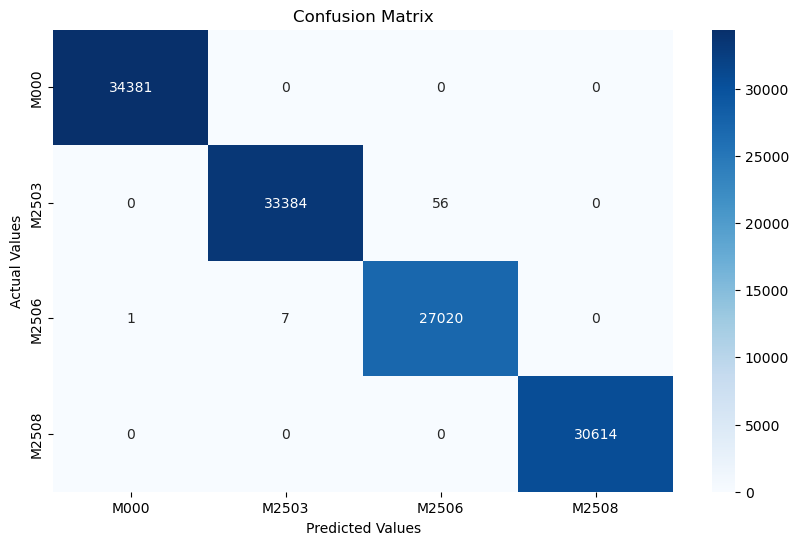

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34381
           1       1.00      1.00      1.00     33440
           2       1.00      1.00      1.00     27028
           3       1.00      1.00      1.00     30614

    accuracy                           1.00    125463
   macro avg       1.00      1.00      1.00    125463
weighted avg       1.00      1.00      1.00    125463

Test Accuracy: 0.9994898894494791
Weighted Precision: 0.9994905990847313
Weighted Recall: 0.9994898894494791
Weighted F1 Score: 0.999489931704724


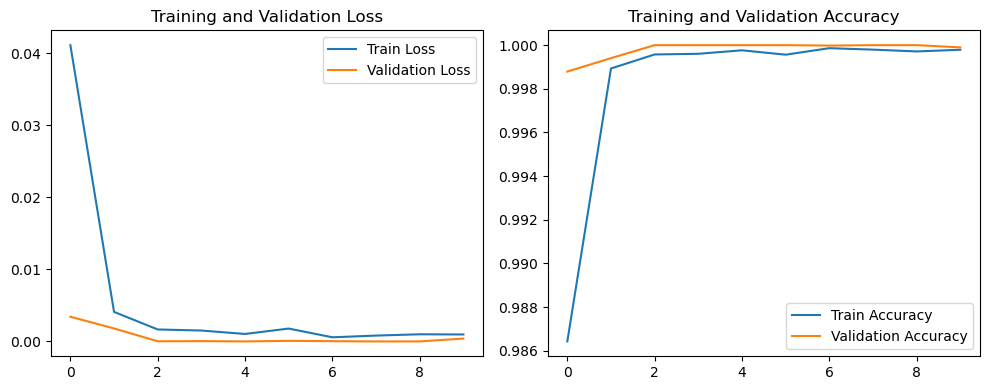

In [15]:
model.evaluate(y_pred, actual_labels)
